In [25]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

In [2]:
f = h5py.File("/st/datasets/gdr3-catalog-master.hdf5", "r")

In [3]:
n = f["source_id"].size
n1m = 10_000_000

In [64]:
flagmask = mask = f["flags"][:n] == 0  # | (f["flags"][:n] == 2)
mask1m = f["flags"][:n1m] == 0
flagmask.sum(), mask1m.sum()

(2546699, 153896)

KeyboardInterrupt: 

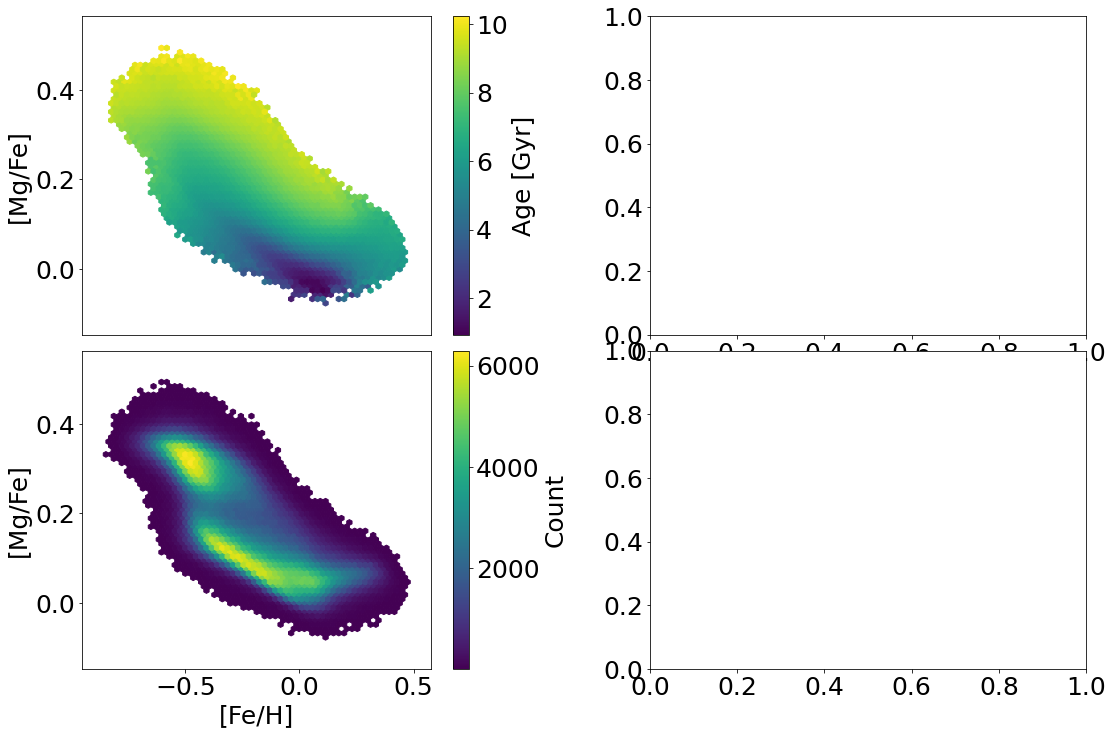

In [65]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.3)

ax = np.stack(
    [np.array([fig.add_subplot(gs[i, j]) for j in range(2)]) for i in range(2)]
)

# top left
hb = ax[0, 0].hexbin(
    f["feh"][:n, 2][flagmask],
    f["mgfe"][:n, 2][flagmask],
    C=f["age"][:n, 2][flagmask],
    mincnt=3,
    gridsize=60,
)
ax[0, 0].xaxis.set_visible(False)
# ax[0,0].set_xlabel("[Fe/H]")
ax[0, 0].set_ylabel("[Mg/Fe]")
plt.colorbar(hb, ax=ax[0, 0], label="Age [Gyr]")

# bottom left
hb = ax[1, 0].hexbin(
    f["feh"][:n, 2][mask],
    f["mgfe"][:n, 2][mask],
    mincnt=3,
    gridsize=60,
)
ax[1, 0].set_xlabel("[Fe/H]")
ax[1, 0].set_ylabel("[Mg/Fe]")
plt.colorbar(hb, ax=ax[1, 0], label="Count")

# top right
hb = ax[0, 1].hexbin(
    f["teff"][:n, 2][mask],
    f["logg"][:n, 2][mask],
    C=f["feh"][:n, 2][mask],
    mincnt=3,
    gridsize=80,
)
# ax[0, 1].set_xlabel("T$_{eff}$")
ax[0, 1].xaxis.set_visible(False)
ax[0, 1].set_ylabel("logg")
ax[0, 1].invert_xaxis()
ax[0, 1].invert_yaxis()
plt.colorbar(hb, ax=ax[0, 1], label="Age [Gyr]")

# bottom right
hb = ax[1, 1].hexbin(
    f["teff"][:n, 2][mask],
    f["logg"][:n, 2][mask],
    mincnt=3,
    gridsize=80,
)
ax[1, 1].set_xlabel("T$_{eff}$")
ax[1, 1].set_ylabel("logg")
ax[1, 1].invert_xaxis()
ax[1, 1].invert_yaxis()
plt.colorbar(hb, ax=ax[1, 1], label="Count")

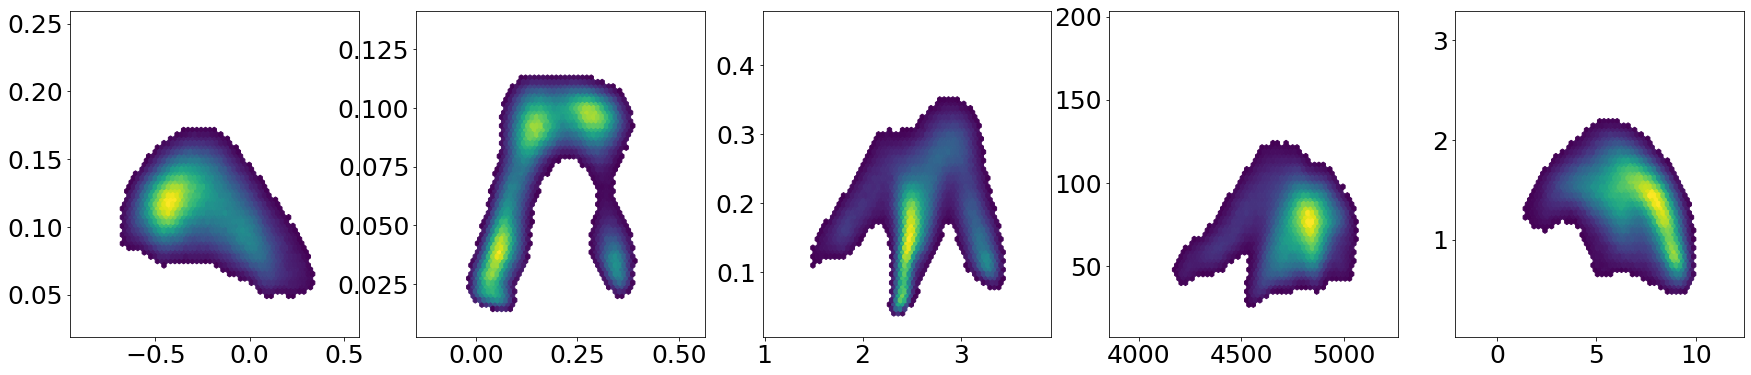

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30, 6))

for i, j in enumerate(["feh", "mgfe", "logg", "teff", "age"]):
    ax[i].hexbin(
        f[j][:n, 2][mask],
        np.mean(np.diff(f[j][:n, 1:4][mask], axis=1), axis=1),
        gridsize=60,
        mincnt=500,
    )

In [8]:
pos = np.load("/st/datasets/radecplx.npy")

In [ ]:
matches, idx1, idx2 = np.intersect1d(
    f["source_id"][:], pos["source_id"], return_indices=True
)

In [ ]:
pos = pos[idx2]

In [ ]:
matchidx = pos["source_id"].argsort()[f["source_id"][:].argsort().argsort()]

In [ ]:
pos = pos[matchidx]

In [ ]:
n

In [14]:
f.create_dataset(
    name="ra",
    dtype="<f8",
    shape=(n,),
    chunks=True,
    compression="lzf",
    shuffle=True,
    data=pos["ra"],
)
f.create_dataset(
    name="dec",
    dtype="<f8",
    shape=(n,),
    chunks=True,
    compression="lzf",
    shuffle=True,
    data=pos["dec"],
)
f.create_dataset(
    name="parallax",
    dtype="<f4",
    shape=(n,),
    chunks=True,
    compression="lzf",
    shuffle=True,
    data=pos["parallax"].astype("float32"),
)
f.create_dataset(
    name="parallax_error",
    dtype="<f4",
    shape=(n,),
    chunks=True,
    compression="lzf",
    shuffle=True,
    data=pos["parallax_error"],
)

<HDF5 dataset "parallax_error": shape (142350681,), type "<f4">

In [15]:
import astropy.units as u
from astropy.coordinates import Distance, SkyCoord
from dustmaps import sfd

Configuration file not found:

    /home/js/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [17]:
coords = SkyCoord(ra=pos["ra"] * u.deg, dec=pos["dec"] * u.deg, frame="icrs")

In [18]:
sfdquery = sfd.SFDQuery()

In [19]:
ebv = sfdquery.query(coords)

In [20]:
f.create_dataset(
    name="sfd_ebv",
    dtype="<f4",
    shape=(n,),
    chunks=True,
    compression="lzf",
    shuffle=True,
    data=ebv,
)

<HDF5 dataset "sfd_ebv": shape (142350681,), type "<f4">

In [21]:
f.close()

In [259]:
plxmask = (f["parallax"][:] / f["parallax_error"][:]) > 10.0
ebvmask = f["sfd_ebv"][:] < 0.1
mask = flagmask & plxmask & ebvmask
thin = 10
mask.sum()

1116513

In [260]:
coords = SkyCoord(
    ra=f["ra"][:][mask][::thin] * u.deg,
    dec=f["dec"][:][mask][::thin] * u.deg,
    distance=Distance(parallax=f["parallax"][:][mask][::thin] * u.mas),
    frame="icrs",
)
gc = coords.galactocentric

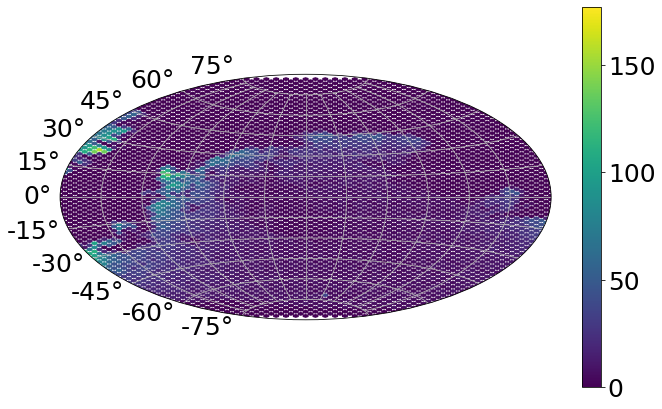

In [277]:
fig = plt.figure()
ax = fig.add_subplot(projection="aitoff")
ax.grid(True)
hb = ax.hexbin(
    coords.ra.wrap_at("180d").rad,
    coords.dec.rad,
    # c=f["feh"][:, 2][mask][::thin],
    # alpha=0.1,
    # bins=(60, 60),
    # gridsize=60,
    # mincnt=1,
)
ax.xaxis.set_ticklabels([])
plt.colorbar(hb)

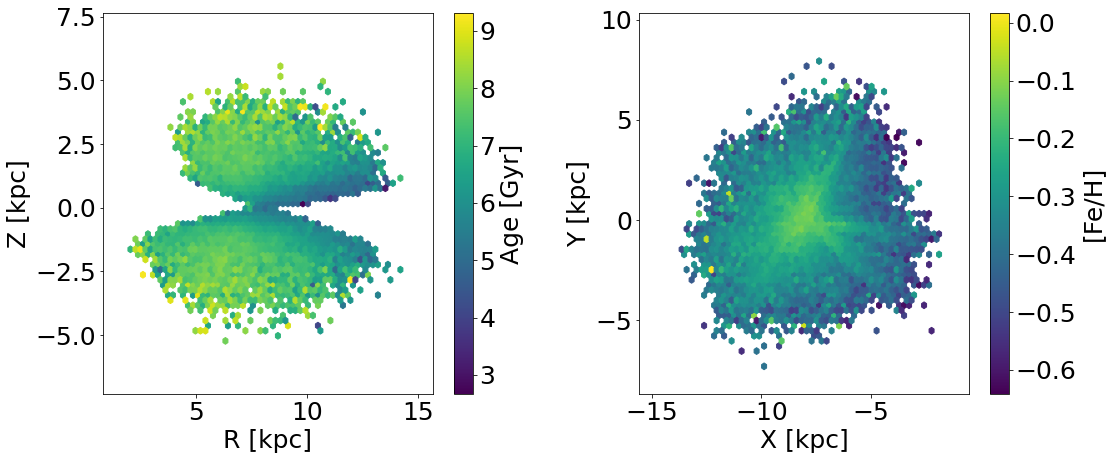

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

hb = ax[0].hexbin(
    np.sqrt(gc.x**2 + gc.y**2).to(u.kpc),
    gc.z.to(u.kpc),
    C=f["age"][:][mask & plxmask][::thin],
    gridsize=60,
    mincnt=1,
)
plt.colorbar(hb, ax=ax[0], label="Age [Gyr]")
ax[0].set_xlabel("R [kpc]")
ax[0].set_ylabel("Z [kpc]")

hb = ax[1].hexbin(
    gc.x.to(u.kpc),
    gc.y.to(u.kpc),
    C=f["feh"][:][mask & plxmask][::thin],
    gridsize=60,
    mincnt=1,
)
ax[1].set_xlabel("X [kpc]")
ax[1].set_ylabel("Y [kpc]")
plt.colorbar(hb, ax=ax[1], label="[Fe/H]")

plt.subplots_adjust(wspace=0.3)

In [20]:
velocities = pd.read_csv("/st/datasets/gdr3-velocities.csv").dropna()

In [279]:
thin = 4
match, idx1, idx2 = np.intersect1d(
    f["source_id"][:][mask][::thin],
    velocities["source_id"].to_numpy(),
    return_indices=True,
)

In [280]:
coords = SkyCoord(
    ra=f["ra"][:][mask][::thin][idx1] * u.deg,
    dec=f["dec"][:][mask][::thin][idx1] * u.deg,
    distance=Distance(parallax=f["parallax"][:][mask][::thin][idx1] * u.mas),
    pm_ra_cosdec=velocities["pmra"].to_numpy()[idx2]
    * np.cos(f["dec"][:][mask][::thin][idx1] * u.deg.to(u.rad))
    * u.mas
    / u.yr,
    pm_dec=velocities["pmdec"].to_numpy()[idx2] * u.mas / u.yr,
    radial_velocity=velocities["radial_velocity"].to_numpy()[idx2] * u.km / u.s,
    frame="icrs",
)
gc = coords.galactocentric

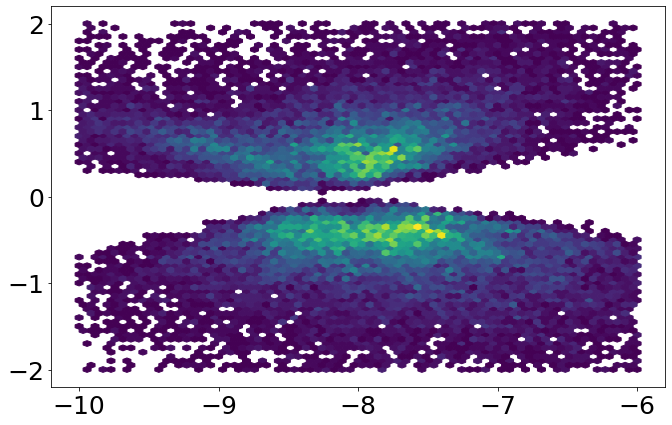

In [281]:
plt.hexbin(
    gc.x.to(u.kpc), gc.z.to(u.kpc), gridsize=70, mincnt=1, extent=[-10, -6, -2, 2]
)

In [73]:
close = np.sqrt((gc.x + gc.galcen_distance) ** 2 + gc.y**2).to(u.kpc) < 1 * u.kpc

In [127]:
from astropy.modeling import fitting, models

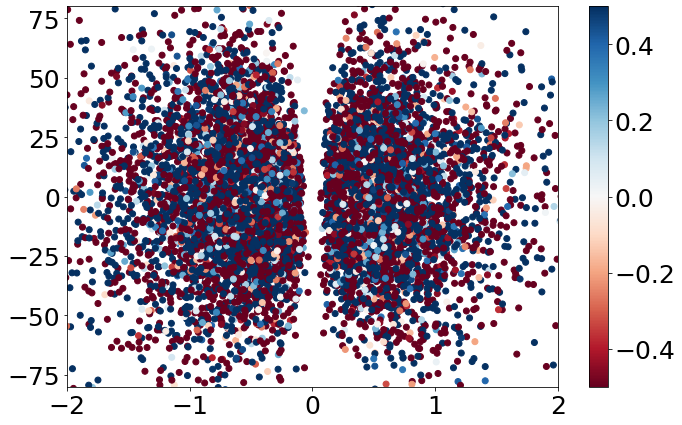

In [193]:
# plt.scatter(
#     gc.z[close].to(u.kpc),  # / np.std(gc.z[close].to(u.kpc)),
#     gc.v_z[close],  # / np.std(gc.v_z[close]),
#     c=f["age"][:, 2][mask][::thin][idx1][close],
# )
plt.xlim(-2, 2)
plt.ylim(-80, 80)

w = models.Polynomial2D(degree=10)
fit_w = fitting.LevMarLSQFitter()
g = fit_w(
    w,
    gc.z[close].to(u.kpc).value,
    gc.v_z[close].value,
    f["age"][:, 2][mask][::thin][idx1][close],
)
plt.scatter(
    gc.z[close].to(u.kpc).value,
    gc.v_z[close].value,
    c=g(gc.z[close].to(u.kpc).value, gc.v_z[close].value)
    - f["age"][:, 2][mask][::thin][idx1][close],
    cmap="RdBu",
    norm=matplotlib.colors.CenteredNorm(0, halfrange=0.5),
)
plt.colorbar()

(-100.0, 100.0)

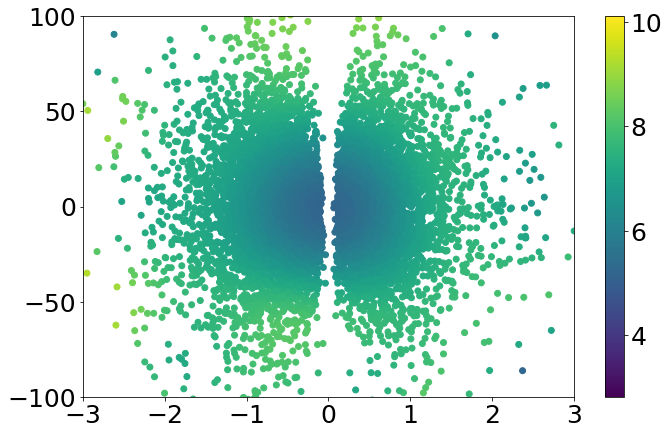

In [194]:
plt.scatter(
    gc.z[close].to(u.kpc).value,
    gc.v_z[close].value,
    c=g(gc.z[close].to(u.kpc).value, gc.v_z[close].value),
)
plt.colorbar()
plt.xlim(-3, 3)
plt.ylim(-100, 100)

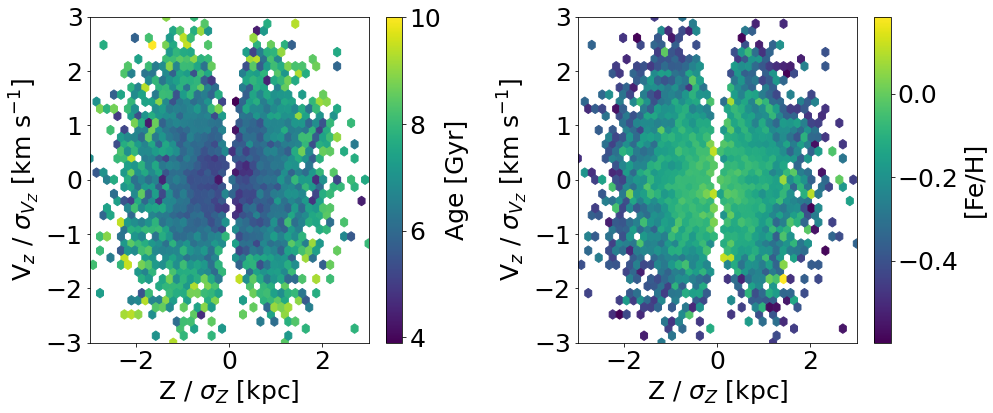

In [282]:
xlim = (-3, 3)
ylim = (-3, 3)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
hb = ax[0].hexbin(
    gc.z[close].to(u.kpc) / np.std(gc.z[close].to(u.kpc)),
    gc.v_z[close] / np.std(gc.v_z[close]),
    C=f["age"][:, 2][mask][::thin][idx1][close],
    gridsize=40,
    extent=[*xlim, *ylim],
    mincnt=1,
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
plt.colorbar(hb, ax=ax[0], label="Age [Gyr]")
ax[0].set_xlabel("Z / $\sigma_Z$ [kpc]")
ax[0].set_ylabel("V$_z$ / $\sigma_{V_{Z}}$ [km s$^{-1}$]")

hb = ax[1].hexbin(
    gc.z[close].to(u.kpc) / np.std(gc.z[close].to(u.kpc)),
    gc.v_z[close] / np.std(gc.v_z[close]),
    C=f["feh"][:, 2][mask][::thin][idx1][close],
    gridsize=40,
    extent=[*xlim, *ylim],
    mincnt=1,
)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
plt.colorbar(hb, ax=ax[1], label="[Fe/H]")
ax[1].set_xlabel("Z / $\sigma_Z$ [kpc]")
ax[1].set_ylabel("V$_z$ / $\sigma_{V_{Z}}$ [km s$^{-1}$]")

plt.subplots_adjust(wspace=0.4)

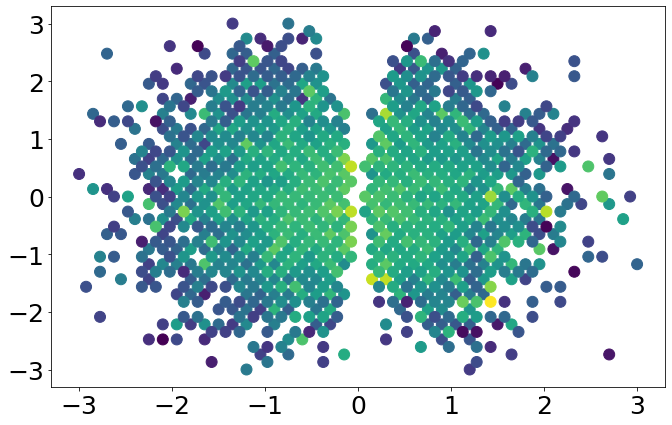

In [231]:
counts = hb.get_array()
verts = hb.get_offsets()
plt.scatter(verts[:, 0], verts[:, 1], c=counts, s=120)

In [285]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from scipy.signal import savgol_filter

In [286]:
o = Orbit(coords)
ts = np.linspace(0.0, 1.0, 500) * u.Gyr
o.integrate(ts, MWPotential2014, numcores=12)

  0%|          | 0/34258 [00:00<?, ?it/s]

In [287]:
jz = o.jz(MWPotential2014)
jr = o.jr(MWPotential2014)
jp = o.jp(MWPotential2014)
lz = o.Lz()
jtot = np.sum(np.abs((lz, jr, jz)), axis=0)
# jtot = np.sqrt(np.sum(np.square((lz, jr, jz)), axis=0))

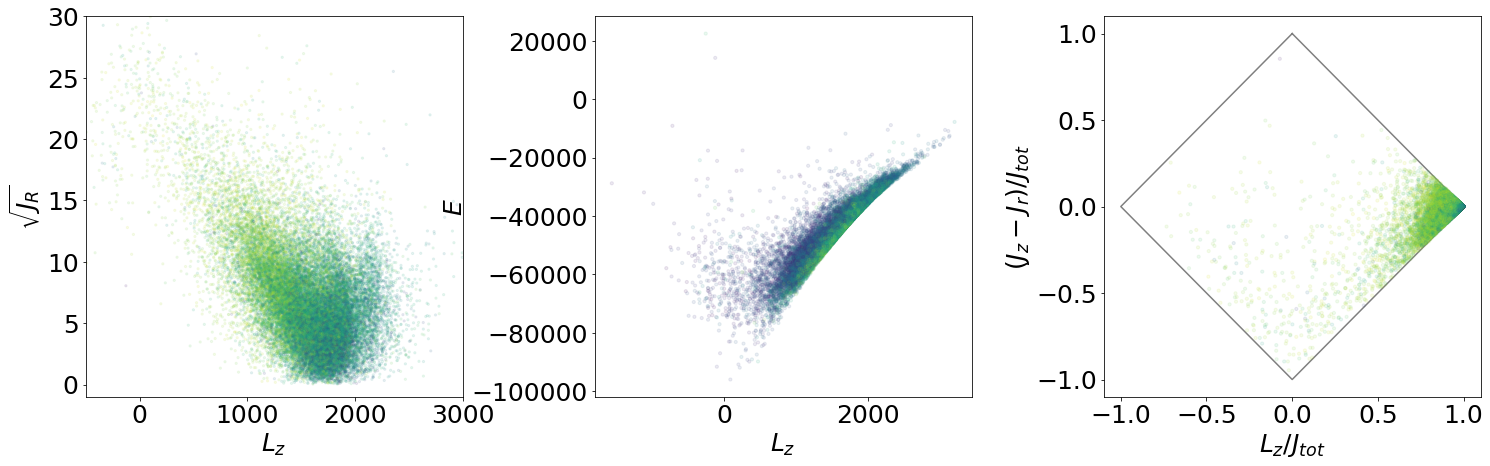

In [302]:
fig = plt.figure(figsize=(25, 7))

ax0 = fig.add_subplot(131)
ax0.scatter(lz, np.sqrt(jr), c=f["age"][:, 2][mask][::thin][idx1], s=5, alpha=0.1)
ax0.set_ylim(-1, 30)
ax0.set_xlim(-500, 3000)
ax0.set_xlabel(r"$L_z$")
ax0.set_ylabel(r"$\sqrt{J_R}$")

ax1 = fig.add_subplot(132)
ax1.scatter(lz, o.E(), c=f["feh"][:, 2][mask][::thin][idx1], s=10, alpha=0.1)
ax1.set_xlabel(r"$L_z$")
ax1.set_ylabel(r"$E$")

ax2 = fig.add_subplot(133)
ax2.scatter(
    lz / jtot, (jz - jr) / jtot, c=f["age"][:, 2][mask][::thin][idx1], s=10, alpha=0.1
)
ax2.set_xlabel(r"$L_z / J_{tot}$")
ax2.set_ylabel(r"$(J_z - J_r) / J_{tot}$")
plt.plot([0, 1, 0, -1, 0], [1, 0, -1.0, 0.0, 1], zorder=-1, c="k", alpha=0.5)

plt.subplots_adjust(wspace=0.35)

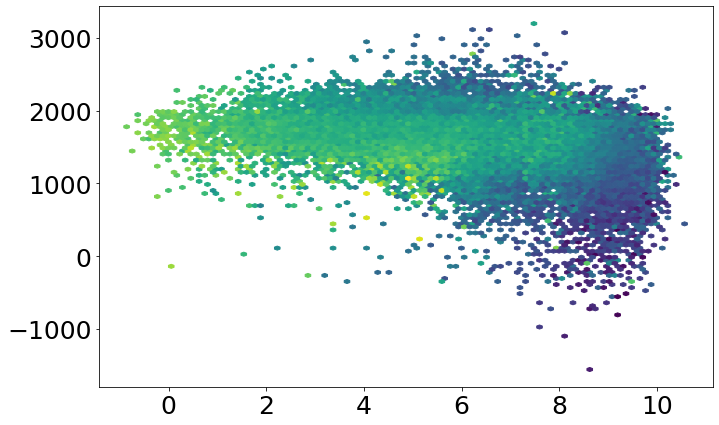

In [304]:
plt.hexbin(f["age"][:, 2][mask][::thin][idx1], jp, C=f["feh"][:, 2][mask][::thin][idx1])

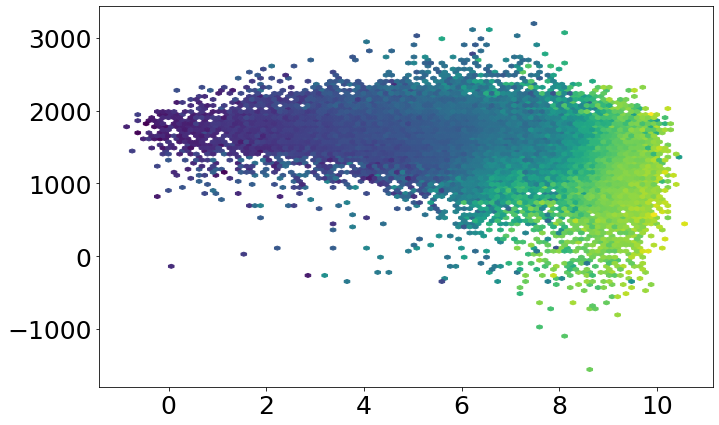

In [303]:
plt.hexbin(
    f["age"][:, 2][mask][::thin][idx1], jp, C=f["mgfe"][:, 2][mask][::thin][idx1]
)

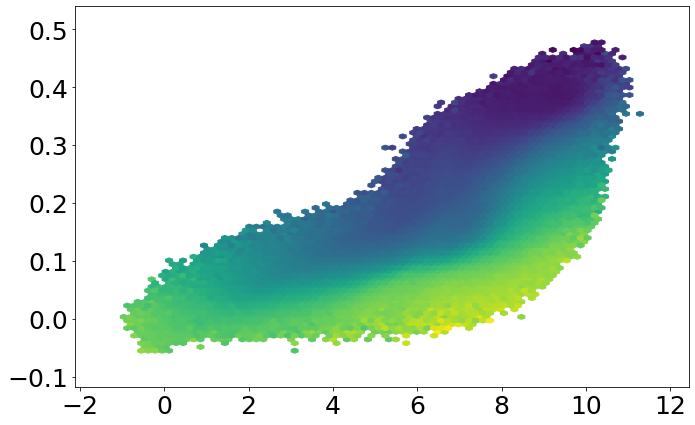

In [234]:
plt.hexbin(
    f["age"][:, 2][mask],
    f["mgfe"][:, 2][mask],
    C=f["feh"][:, 2][mask],
    gridsize=80,
    mincnt=2,
)

In [12]:
f.create_dataset(
    "5nn_feature_distance",
    shape=(142350681,),
    dtype="<f4",
    data=f["distances"][:],
    chunks=True,
    shuffle=True,
    compression="lzf",
)
del f["distances"]
f.close()